# Quantum Partition Function

The partition function is of particular interest for calculating probabilities from graphical models such Markov random fields [1]. It 
becomes intractable even for small networks [2]. In this example, the graphical model form known as the Potts model is considered. The
 efficient quantum algorithm is implemented for the partition function [3]. The full partition function algorithm consists of the 
 following four steps:
 
 * step 1: Classical Preprocessing
 * step 2: Irreducible Cyclic Cocycle Code Check
 * step 3: State Preparation and Quantum Fourier Transform
 * step 4: Classical Post-Processing

# References

[1] Koller, Daphne, and Nir Friedman. Probabilistic graphical models: principles and techniques. MIT press, 2009.

[2] Adedoyin, Adetokunbo, et al. "Quantum algorithm implementations for beginners." arXiv preprint arXiv:1804.03719 (2018).

[3] Geraci, Joseph, and Daniel A. Lidar. "On the exact evaluation of certain instances of the Potts partition function by quantum computers." Communications in mathematical physics 279.3 (2008): 735-768.

In [25]:
import matplotlib.pyplot as plt

from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.experimental.algorithms.quantum_partition_function.quantum_partition_function import (
    quantum_partition_function,
    run_quantum_partition_function,
    get_quantum_partition_function_results,
)

import networkx as nx

# magic word for producing visualizations in notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
potts_model = {}

# Step 1: Classical Preprocessing

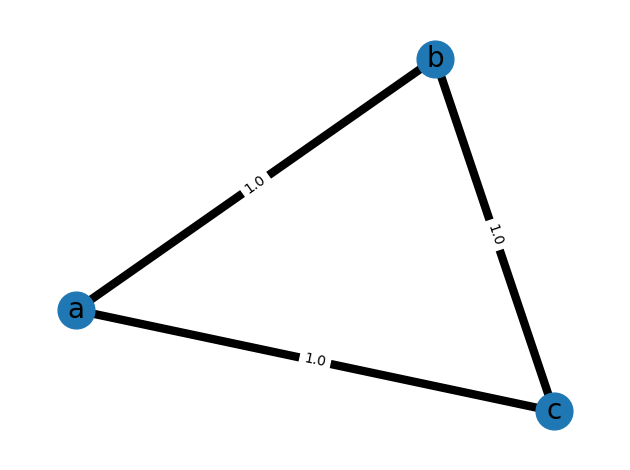

In [15]:
G = nx.Graph()

G.add_edge("a", "b", weight=1.0)
G.add_edge("a", "c", weight=1.0)
G.add_edge("b", "c", weight=1.0)

edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=6)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
step = 'pre'
potts_model['graph-model'] = G
potts_model['q-state'] = 2

In [17]:
step1_result = run_quantum_partition_function(potts_model, step)
potts_model.update(step1_result)

Classical Preprocessing to [n,k] Code


# Step 2: Irreducible Cyclic Cocycle Code (ICCC) Check

In [18]:
step = 'iccc-check'

In [19]:
step2_result = run_quantum_partition_function(potts_model, step)
potts_model.update(step2_result)

Irreducible Cyclic Cocycle Code Check
The cycle matroid matrix of Graph Gamma is 2 x 3
the ICCC is [1,-1], which passes ICCC check!


# Step 3: State Preparation and Quantum Fourier Transform

In [28]:
num_qubits = 2
qubits=range(num_qubits)
q0 = qubits[0]
q1 = qubits[1]
pi = 3.14

# Prepare state for quantum fourier circuit
quantum_partition_function_qft = Circuit().h(range(2)).rz(q0,-pi).rz(q1,pi)
qft_circ = quantum_partition_function('qft', qubits)
quantum_partition_function_qft.add(qft_circ)

print("State Preparation and Quantum Fourier Transform Circuit:")
print(quantum_partition_function_qft)

qft circuit for checking gamma values
State Preparation and Quantum Fourier Transform Circuit:
T  : |0|    1    |2|     3     |4| 5  |
                                       
q0 : -H-Rz(-3.14)-H-PHASE(1.57)---SWAP-
                    |             |    
q1 : -H-Rz(3.14)----C-----------H-SWAP-

T  : |0|    1    |2|     3     |4| 5  |


In [32]:
potts_model['qft-func'] = {}
potts_model['qft-func']['circuit'] = quantum_partition_function_qft
potts_model['qft-func']['param'] = {}
potts_model['qft-func']['param']['shots'] = 1000

step = 'qft'

## Run on a local simulator

Quantum Partition Function Running
State Preparation and Quantum Fourier Transform
Quantum Partition Function Run Complete
Status of task: COMPLETED
Counter({'11': 523, '01': 477})


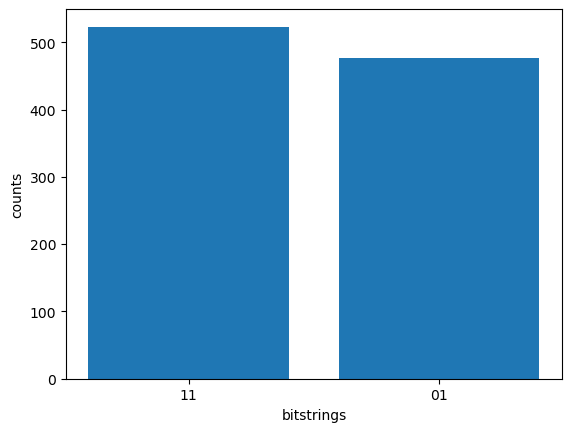

In [33]:
potts_model['qft-func']['param']['device'] = LocalSimulator()

print("Quantum Partition Function Running")
step3_result = run_quantum_partition_function(potts_model, step)
potts_model.update(step3_result)

print("Quantum Partition Function Run Complete")
get_quantum_partition_function_results(potts_model)

## Run on a QPU

In [ ]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

t = Tracker().start()

In [ ]:
# UNCOMMENT the follow code block to run on the QPU
"""
qpu = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

potts_model['qft-func']['param']['device'] = qpu

print("Quantum Partition Function Running")
step3_result = run_quantum_partition_function(potts_model, step)
potts_model.update(step3_result)

print("Quantum Partition Function Run Complete")
get_quantum_partition_function_results(potts_model)

""""

In [ ]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD"
)

# Step4: Classical Post-Processing

Threshold the low-probability values of gamma, ensuring no more than the maximum number of distinct values of gamma remain. These gammas are then plugged into the calculation of the weight spectrum and the partition function